# MNIST Project

## Imports

In [1]:
import torch
from torch import Tensor 
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.autograd import Variable
import src.dlc_practical_prologue as prologue
import matplotlib.pyplot as plt

## Loading the Data

In [4]:
N = 1000
train_X, train_Y, train_Class, test_X, test_Y, test_Class = prologue.generate_pair_sets(N)

In [6]:
%%capture
mu, std = train_X.mean(), train_X.std()
train_X.sub_(mu).div_(std)
test_X.sub_(mu).div_(std)

## Model 1: Naive convnet
For the first model, we create a naive convnet, not taking into account the structrue of the channels.

In [7]:
class convNet(nn.Module):
    def __init__(self):
        super(convNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [8]:
def train_model(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, verbose=False):
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model

In [9]:
def train_model_path(model, criterion, optimizer, nb_epochs, minibatch_size, train_X, train_Y, test_X, test_Y, verbose=False):
    train_error = []
    test_error = []
    for e in range(nb_epochs):
        for b in range(0, train_X.size(0), minibatch_size):
            out = model(train_X.narrow(0, b, minibatch_size))
            loss = criterion(out, train_Y.narrow(0, b, minibatch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
        train_error.append(compute_nb_errors(model, train_X, train_Y, minibatch_size))
        test_error.append(compute_nb_errors(model, test_X, test_Y, minibatch_size))
        if(verbose): print(compute_nb_errors(model, train_X, train_Y, minibatch_size))
    return model, train_error, test_error

In [10]:
def compute_nb_errors(model, data_input, data_target, minibatch_size):
    nb_data_errors = 0
    for b in range(0, data_input.size(0), minibatch_size):
        out = model(data_input.narrow(0, b, minibatch_size))
        _, pred = torch.max(out.data, 1)
        for k in range(minibatch_size):
            if data_target[b+k] != pred[k]:
                nb_data_errors += 1
    return nb_data_errors

In [11]:
model1 = convNet()
model1, train_path, test_path = train_model_path(model1, nn.CrossEntropyLoss(), optim.SGD(model1.parameters(), lr=1e-1), \
                                                 100, 100, train_X, train_Y, test_X, test_Y, verbose=False)

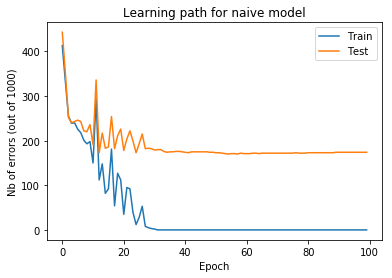

Final Test Error: 174/1000


In [12]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for naive model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(model1, test_X, test_Y, 100)))

We observe that this model does not manage to learn the mapping very well.

## Model 2: Using transfer learning

### Part 1: Study of a good functioning digit detection network for 28x28 images

In [13]:
train_input, train_target, test_input, test_target = \
    prologue.load_data(one_hot_labels = False, normalize = True, flatten = False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(256, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=3, stride=3))
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2))
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [14]:
train_input, train_target = Variable(train_input), Variable(train_target)
model = Net()

In [15]:
model = train_model(model, nn.CrossEntropyLoss(), optim.SGD(model.parameters(), lr=1e-1), 50, 100, train_input, train_target)

In [16]:
print('Final Test Error: {}/1000'.format(compute_nb_errors(model, test_input, test_target, 100)))

Final Test Error: 61/1000


### Part 2: Adapting the network to 14x14 images

In [17]:
# fist, create the training and testing dataset
train_target_14px = torch.cat((train_Class[:,0], train_Class[:,1]))
train_input_14px = torch.cat((train_X[:,0,:,:].view(1000,1,14,14), train_X[:,1,:,:].view(1000,1,14,14)))

test_target_14px = torch.cat((test_Class[:,0], test_Class[:,1]))
test_input_14px = torch.cat((test_X[:,0,:,:].view(1000,1,14,14), test_X[:,1,:,:].view(1000,1,14,14)))

train_input_14px, train_target_14px = Variable(train_input_14px), Variable(train_target_14px)

In [18]:
class Net_14px(nn.Module):
    def __init__(self):
        super(Net_14px, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x = F.relu(self.fc1(x.view(-1, 256)))
        x = self.fc2(x)
        return x

In [19]:
model_14px = Net_14px()
model_14px, train_path, test_path = train_model_path(model_14px, nn.CrossEntropyLoss(), optim.SGD(model_14px.parameters(), lr=1e-1), 50, 100, \
                         train_input_14px, train_target_14px, test_input_14px, test_target_14px, verbose=False)

983
1139
436
259
176
137
119
100
81
74
66
60
54
47
45
41
39
38
34
31
31
28
26
26
25
20
20
17
16
13
13
13
12
8
8
7
5
5
5
4
3
3
3
3
2
2
2
2
2
1


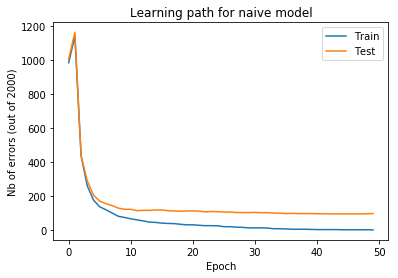

Final Test Error: 97/2000


In [20]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for 14px digit detection model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 2000)')
plt.legend()
plt.show()
print('Final Test Error: {}/2000'.format(compute_nb_errors(model_14px, test_input_14px, test_target_14px, 100)))


Now, let's define the siamese model with parameter sharing:

In [53]:
class siamese_Net(nn.Module):
    def __init__(self):
        super(siamese_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(256, 100)
        self.fc3 = nn.Linear(200, 10)
        self.fc4 = nn.Linear(10,2)

    def forward(self, x):
        x1 = F.relu(F.max_pool2d(self.conv1(x[:,0,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x1 = F.relu(self.fc1(x1.view(-1, 256)))
        x2 = F.relu(F.max_pool2d(self.conv1(x[:,1,:,:].view(x.size(0),1,14,14)), kernel_size=2, stride=2)) #image size 12x12-> image size 6x6
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=2, stride=2)) #image size 4x4 -> image size 2x2
        x2 = F.relu(self.fc1(x2.view(-1, 256)))
        x = F.relu(self.fc3(torch.cat((x1.view(-1,100), x2.view(-1, 100)), 1)))
        x = self.fc4(x)
        return x

In [54]:
sNet = siamese_Net()

In [55]:
torch.save(model_14px.state_dict(), 'networks/model_14px.pt')

In [56]:
sNet.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [57]:
sNet, train_path, test_path = train_model_path(sNet, nn.CrossEntropyLoss(), optim.SGD(sNet.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

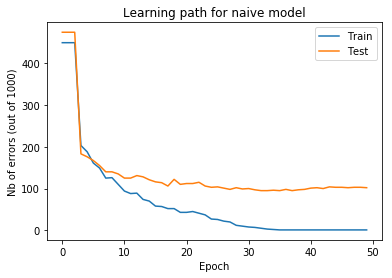

Final Test Error: 102/1000


In [58]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for transfer learning siamese model')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet, test_X, test_Y, 100)))

# Model 3: Siamese Net without Pretraining

In [35]:
sNet2 = siamese_Net()

In [36]:
sNet2, train_path, test_path = train_model_path(sNet2, nn.CrossEntropyLoss(), optim.SGD(sNet2.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

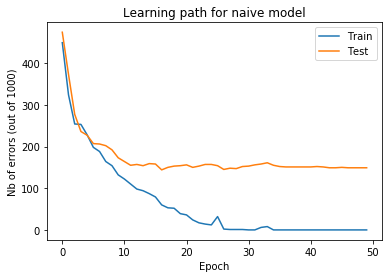

Final Test Error: 149/1000


In [37]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for siamese model without pretraining')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet2, test_X, test_Y, 100)))

## Model 4: With Pretraining, not updating the convolution layer parameters:
Therefore keeping the feature extractor

In [104]:
sNet3 = siamese_Net()

In [105]:
sNet3.load_state_dict(torch.load('networks/model_14px.pt'), strict=False)

In [106]:
for p in sNet3.conv1.parameters():
    p.requires_grad = False
for p in sNet3.conv2.parameters():
    p.requires_grad = False

In [107]:
sNet3, train_path, test_path = train_model_path(sNet3, nn.CrossEntropyLoss(), optim.SGD(sNet3.parameters(), lr=1e-1), \
                                                 50, 100, train_X, train_Y, test_X, test_Y, verbose=False)

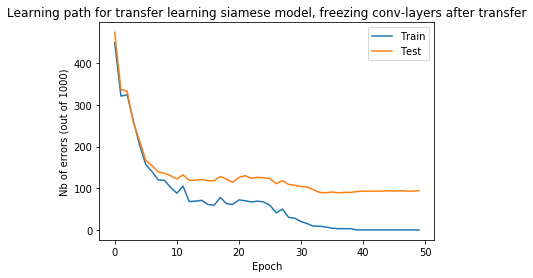

Final Test Error: 94/1000


In [108]:
plt.plot(train_path, label = 'Train')
plt.plot(test_path, label = 'Test')
plt.title('Learning path for transfer learning siamese model, freezing conv-layers after transfer')
plt.xlabel('Epoch')
plt.ylabel('Nb of errors (out of 1000)')
plt.legend()
plt.show()
print('Final Test Error: {}/1000'.format(compute_nb_errors(sNet3, test_X, test_Y, 100)))